# Chance-Constrained DC Optimal Power Flow
The purpose of this tutorial is to show how polynomial chaos can be leveraged to solve optimization problems under uncertainty.
Specifically, we study chance-constrained DC optimal power flow as it is presented in [this paper](https://www.sciencedirect.com/science/article/pii/S235246771830105X).

We consider the following 4-bus system that has a total of two generators (buses 1 and 3) and two loads (buses 2 and 4):

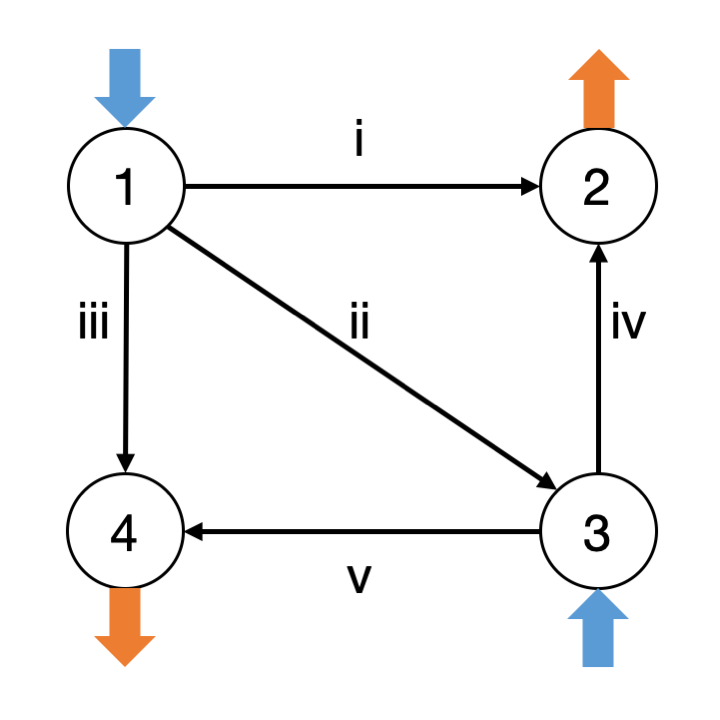

We formalize the numbering of the generators (superscript $g$), loads (superscript $d$ for demand), and branches (superscript $br$) as follows
$$
\mathcal{N}^g = \{ 1, 3\}, \, \mathcal{N}^d = \{ 2, 4\}, \, \mathcal{N}^br = \{ 1, 2, 3, 4, 5 \}.
$$
With each generator we associate a linear cost with cost coefficient $c_i$ for all $i \in \mathcal{N}^g$.
Each generator must adhere to its engineering limits given by $(\underline{p}_i^g , \overline{p}_i^g )$ for all $i \in \mathcal{N}^g$.
Also, each line is constrained by its limits $(\underline{p}_i^{br}, \overline{p}_i^{br})$ for all $i \in \mathcal{N}^{br}$.

We model the demand at the buses $i \in \mathcal{N}^d$ in terms of uniform distributions with known mean $\mu_i$ and standard deviation $\sigma_i$.
We concisely write
$$
\mathsf{p}_i^d \sim \mathsf{U}(\mu_i, \sigma_i) \quad \forall i \in \mathcal{N}^d.
$$
For simplicity we consider DC conditions.
Hence, energy balance reads
$$
\sum_{i \in \mathcal{N}^g} \mathsf{p}_i^g - \sum_{i \in \mathcal{N}^d} \mathsf{p}_i^d = 0,
$$
and the vector of branch flows is computed from the power transfer distribution factor (PTDF) matrix $\Psi$ via
$$
\mathsf{p}^{br} = \Psi (C^p\mathsf{p}^g + C^d\mathsf{p}^d).
$$
The matrices $C^p$ and $C^d$ map the generators and the loads to the correct buses, respectively.

We want to solve a chance-constrained optimal power flow problem under DC conditions.
According to [this paper](https://www.sciencedirect.com/science/article/pii/S235246771830105X), we can formulate the problem as
$$\underset{\mathsf{p^{g}}}{\operatorname{min}} \, \sum_{i \in \mathcal{N}_g} c_i \mathbb{E}( \mathsf{p}_i^g)$$
subject to
$$
\sum_{i \in \mathcal{N}^g} \mathsf{p}_i^g - \sum_{i \in \mathcal{N}^d} \mathsf{p}_i^d = 0, \\
\underline{p}_i^g \leq \mathbb{E}(\mathsf{p}_i^g) \pm \lambda_i^g \sqrt{\mathbb{V}(\mathsf{p}_i^g)} \leq \overline{p}_i^g  \forall i \in \mathcal{N}^g,\\
\underline{p}_i^{br} \leq \mathbb{E}(\mathsf{p}_i^{br}) \pm \lambda_i^{br} \sqrt{\mathbb{V}(\mathsf{p}_i^{br})} \leq \overline{p}_i^{br} \forall i \in \mathcal{N}^{br},
$$
which minimizes the total expected generation cost subject to the DC power flow equations and chance-constrained engineering limits.

Let's solve the problem using `PolyChaos` and `JuMP`, using `Mosek` as a solver.

In [1]:
using PolyChaos, JuMP, MosekTools, LinearAlgebra

Let's define system-specific quantities such as the incidence matrix and the branch flow parameters.
From these we can compute the PTDF matrix $\Psi$ (assuming the slack is at bus 1).

In [2]:
A = [ -1 1 0 0; -1 0 1 0; -1 0 0 1 ; 0 1 -1 0; 0 0 -1 1] # incidence matrix
Nl, N = size(A,1), size(A,2)
Bbr = diagm(0 => -( 2 .+ 10*rand(Nl) )) # line parameters
Ψ = [ zeros(Nl)  -Bbr*A[:,2:end]*inv(A[:,2:end]'*Bbr*A[:,2:end]) ] # PTDF matrix

5×4 Array{Float64,2}:
 0.0  -0.381167  -0.170689  -0.0435176
 0.0  -0.434314  -0.582034  -0.148391 
 0.0  -0.184519  -0.247277  -0.808091 
 0.0  -0.618833   0.170689   0.0435176
 0.0   0.184519   0.247277  -0.191909 

Now we can continue the remaining ingredients that specify our systems:

In [3]:
Cp, Cd = [1 0; 0 0; 0 0; 0 1], [0 0; 1 0; 0 1; 0 0 ] # book-keeping
Ng, Nd = size(Cp,2), size(Cd,2) 
c = 4 .+ 10*rand(Ng) # cost function parameters
λp, λl = 1.6*ones(Ng), 1.6*ones(Nl) # lambdas for chance constraint reformulations
pmax, pmin = 10*ones(Ng), zeros(Ng) # engineering limits
plmax, plmin = 10*ones(Nl), -10*ones(Nl) # engineering limits

([10.0, 10.0, 10.0, 10.0, 10.0], [-10.0, -10.0, -10.0, -10.0, -10.0])

We specify the uncertainty using `PolyChaos`:

In [4]:
deg = 1
opq = [Uniform01OrthoPoly(deg; Nrec=5*deg), Uniform01OrthoPoly(deg; Nrec=5*deg)]
mop = MultiOrthoPoly(opq, deg)
Npce = mop.dim

3

It remains to specify the PCE coefficients, for which we will use `convert2affine`.

In [5]:
d = zeros(Nd,Npce) # PCE coefficients of load
d[1,[1,2]] = convert2affinePCE(1., 0.1, mop.uni[1], kind="μσ")
d[2,[1,3]] = convert2affinePCE(2., 0.2, mop.uni[2], kind="μσ")

2-element Array{Float64,1}:
 2.0               
 0.6928203230275509

Now, let's put it all into an optimization problem, specifically a second-order cone program.
To build the second-order cone constraints we define a helper function `buildSOC`.

In [6]:
function buildSOC(x::Vector,mop::MultiOrthoPoly)
    t = [ sqrt(Tensor(2,mop).get([i,i])) for i in 0:mop.dim-1 ]
    (t.*x)[2:end]
end

buildSOC (generic function with 1 method)

Finally, let's use `JuMP` to formulate and then solve the problem.

In [7]:
model = Model(with_optimizer(Mosek.Optimizer))
@variable(model, p[i in 1:Ng,j in 1:Npce], base_name="p")
@constraint(model, energy_balance[j in 1:Npce], sum(p[i,j] for i in 1:Ng) - sum(d[i,j] for i in 1:Nd) == 0)
@constraint(model, con_pmax[i in 1:Ng], [1/λp[i]*(pmax[i] - mean(p[i,:],mop)); buildSOC(p[i,:],mop)] in SecondOrderCone())
@constraint(model, con_pmin[i in 1:Ng], [1/λp[i]*(mean(p[i,:],mop) - pmin[i]); buildSOC(p[i,:],mop)] in SecondOrderCone())
pl = Ψ*(Cp*p + Cd*d)
@constraint(model, con_plmax[i in 1:Nl], [1/λl[i]*(plmax[i] - mean(pl[1,:],mop)); buildSOC(pl[i,:],mop)] in SecondOrderCone())
@constraint(model, con_plmin[i in 1:Nl], [1/λl[i]*(mean(pl[1,:],mop) - plmin[i]); buildSOC(pl[i,:],mop)] in SecondOrderCone())
@objective(model, Min, sum( mean(p[i,:],mop)*c[i] for i in 1:Ng) )
optimize!(model) # here we go

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 45              
  Cones                  : 14              
  Scalar variables       : 48              
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.01    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 45              
  Cones               

Let's extract the numerical values of the optimal solution.

In [8]:
@assert termination_status(model) == MOI.OPTIMAL "Model not solved to optimality."
psol, plsol, obj = value.(p), value.(pl), objective_value(model)

([5.85252e-9 -6.8734e-10 -1.45066e-9; 3.0 0.34641 0.69282], [-0.853098 -0.147115 -0.148407; -2.04356 -0.201855 -0.506053; … ; -0.146902 -0.199295 0.148407; 0.103347 -0.00256 0.0383604], 39.21411604774516)

Great, we've solved the problem.
How do we now make sense of the solution?
For instance, we can look at the moments of the generated power:

In [9]:
p_moments = [ [mean(psol[i,:],mop) var(psol[i,:],mop) ] for i in 1:Ng ]

2-element Array{Array{Float64,2},1}:
 [5.85252e-9 2.14739e-19]
 [3.0 0.05]              

Simiarly, we can study the moments for the branch flows:

In [10]:
pbr_moments = [ [mean(plsol[i,:],mop) var(plsol[i,:],mop) ] for i in 1:Nl ]

5-element Array{Array{Float64,2},1}:
 [-0.853098 0.00363895]
 [-2.04356 0.0247363]  
 [-3.10335 0.0544049]  
 [-0.146902 0.00514526]
 [0.103347 0.000123173]